First we need to install [DARTS](https://unit8co.github.io/darts/)

In [1]:
%%capture
!pip install darts
!pip install sidetable

Then mount GDrive where the data is stored:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import darts
import pandas as pd

from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

from darts import TimeSeries

#this zip is a bunch of zips for each station
zf = ZipFile("/content/drive/MyDrive/PRSA2017_Data_20130301-20170228.zip")

#make a dataframe and unpack all the zips into it
df = pd.DataFrame()
for file in zf.infolist():
    if file.filename.endswith('.csv'):
        df = df._append(pd.read_csv(zf.open(file)))

# the data format is broken into multiple columsn, so we need to fix that into a single DateTime
df['timestamp'] = pd.to_datetime(df[["year", "month", "day", "hour"]])
df.drop(columns=['No'], inplace=True)
df.sort_values(by=['timestamp', 'station']).head(10)

#now turn both wind direction and station name into ints so we can treat them like categorical vars
df = df.replace(df['station'].unique(), list(range(len(df['station'].unique()))))
df = df.replace(df['wd'].unique(), list(range(len(df['wd'].unique()))))

df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,timestamp
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,0.0,4.4,0,2013-03-01 00:00:00
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,1.0,4.7,0,2013-03-01 01:00:00
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,0.0,5.6,0,2013-03-01 02:00:00
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,2.0,3.1,0,2013-03-01 03:00:00
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,1.0,2.0,0,2013-03-01 04:00:00


In [ ]:
import sidetable

df.stb.missing()

,missing,total,percent
year,0,420768,0.0
month,0,420768,0.0
station,0,420768,0.0
WSPM,0,420768,0.0
wd,0,420768,0.0
RAIN,0,420768,0.0
DEWP,0,420768,0.0
PRES,0,420768,0.0
TEMP,0,420768,0.0
O3,0,420768,0.0


In [ ]:
ts_df = df[['PM2.5', 'timestamp', 'station', 'wd', 'WSPM', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'O3', 'CO', 'NO2', 'SO2']]

d = ts_df.timestamp - pd.to_datetime('2013-03-01 00:00:00')

delta_index = []
for delta in d:
    delta_index.append(int(delta.total_seconds()/3600))

ts_df['ts_ind'] = delta_index

#get just the PM2.5, and ts_ind for the target that we want to predict
target_series = TimeSeries.from_group_dataframe(ts_df[["PM2.5", 'ts_ind', 'station']], group_cols=['station'], time_col='ts_ind')
#now everything other than PM2.5 for the covs
cov_series = TimeSeries.from_group_dataframe(ts_df.drop(["PM2.5",'timestamp'], axis=1), group_cols=['station'], time_col='ts_ind')

#
split_point = int(len(cov_series[0]) * 0.8)
split_point_2 = int(len(cov_series[0]) * 0.9)

past_target_series = []
future_target_series = []
test_target_series = []

for ts in target_series:
    past_target_series.append(ts.slice(0, split_point))
    future_target_series.append(ts.slice(split_point, split_point_2))
    test_target_series.append(ts.slice(split_point_2, len(ts)))

past_cov_series = []
future_cov_series = []
test_cov_series = []

for ts in cov_series:
    past_cov_series.append(ts.slice(0, split_point))
    future_cov_series.append(ts.slice(0, split_point_2))
    test_cov_series.append(ts.slice(split_point_2, len(ts)))

<ipython-input-4-c6a27de6b553>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df['ts_ind'] = delta_index


In [ ]:
from darts.models import TCNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import QuantileRegression

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

model = TCNModel(input_chunk_length=24,
                 output_chunk_length=12,
                 dropout=0.1,
                 pl_trainer_kwargs={
                    "accelerator": "gpu",
                    "devices": [0],
                    "callbacks": [early_stop]
                  })

model.fit(past_target_series, past_covariates=past_cov_series, epochs=40)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 272   
----------------------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

TCNModel(kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.1, input_chunk_length=24, output_chunk_length=12, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0], 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7bd9fd733250>]})

In [ ]:
model.save("/content/drive/MyDrive/tcn_model/11_11")

In [ ]:
predict_series = []

for ts in target_series:
    predict_series.append(ts.slice(split_point_2, len(ts)-48))

pred = model.predict(n=48, series=predict_series, past_covariates=cov_series, mc_dropout=True, num_samples=500)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='ts_ind'>

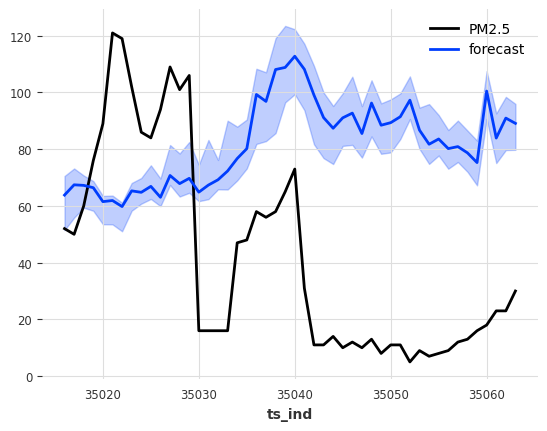

In [ ]:
test_target_series[3][-48:].plot()
pred[3].plot(label='forecast')

In [ ]:
from darts.models import TFTModel

early_stop = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

model = TFTModel(
    input_chunk_length=6,
    output_chunk_length=6,
    n_epochs=20,
    pl_trainer_kwargs={
                    "accelerator": "gpu",
                    "devices": [0],
                    "callbacks": [early_stop]
                  }
)

# future_covariates are mandatory for `TFTModel`
model.fit(past_target_series,
          past_covariates=cov_series,
          future_covariates=cov_series,
          val_series=future_target_series,
          val_future_covariates=future_cov_series,
          val_past_covariates=cov_series)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 528   
4  | encoder_vsn                       | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=6, output_chunk_length=6, n_epochs=20, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0], 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7bd9fb777b80>]})

In [ ]:
model.save("/content/drive/MyDrive/tft_model/11_11")